# Grad-CAM + Grid Display Code in Colab


## imports

In [1]:
# === IMPORTS ===
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from pathlib import Path
from PIL import Image



## definitions to set by user

In [2]:
# set "machine" according to where you want to run the script
machine = 'local' # 'colab' or 'local'

# modelname:
model_name = 'inceptionv3_10'


# size to which the X-ray images have to be converted to (according to the model which is used):
IMG_HEIGHT, IMG_WIDTH = 299, 299

## load directories on colab

In [3]:
if machine == 'colab':
    #from google.colab import files
    #files.upload()

    # load google drive when working on colab
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)


## definitions of paths

In [4]:
if machine == 'local':
#    paths to load data:
    base_path = r"..\\data\\"
    base_path_zip = os.path.join(base_path, "raw")                       # path where zip-file is
    base_path_raw = base_path_zip                                        # path where raw data is unziped to  (on local machine same as path where zip is)
    base_path_processed = os.path.join(base_path, "processed", "DL")     # path where processed data is saved

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"
   
elif machine == 'colab':
    # paths to load data:
    base_path_drive     = '/content/drive/MyDrive/data'         # base path on DRIVE
    base_path_colab     =  '/content/data'                      # base path on COLAB
    base_path_zip       = os.path.join(base_path_drive, 'raw')  # path where zip-file is (on drive)
    base_path_raw       = os.path.join(base_path_colab, 'raw')  # path where raw data is unziped to (on colab machine not on drive)
    base_path_processed = os.path.join(base_path_colab, 'processed')  # path where processed data is saved (on colab machine not on drive)


    # paths to save models:
    model_path = '/content/drive/MyDrive/models/DL'

## load fine-tuned model

In [27]:
# === LOAD FINETUNED MODEL ===

model_file = os.path.join(model_path, model_name + ".keras")

assert tf.io.gfile.exists(model_file), f"Model not found at {model_file}"
base_model = tf.keras.models.load_model(model_file)
print("Base-Model loaded successfully.")

base_model.summary()


Base-Model loaded successfully.


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,493,098 (146.84 MB)

 Trainable params: 13,902,596 (53.03 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

 Optimizer params: 13,902,598 (53.03 MB)

## Get infos about layers in the already trained and fine-tuned model

In [36]:
dummy = np.arange(299*299*3).reshape(299,299,3).astype(np.float32)
dummy = np.expand_dims(dummy, axis=0)  # Adds batch dimension
base_model(dummy)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 1., 0., 0.]], dtype=float32)>

In [6]:
# Get the model's layers
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name} - {layer.__class__.__name__}")

Layer 0: input_layer_7 - InputLayer
Layer 1: inception_v3 - Functional
Layer 2: global_average_pooling2d_3 - GlobalAveragePooling2D
Layer 3: dense_15 - Dense
Layer 4: dropout_6 - Dropout
Layer 5: dense_16 - Dense
Layer 6: dropout_7 - Dropout
Layer 7: dense_17 - Dense
Layer 8: dense_18 - Dense
Layer 9: dense_19 - Dense


In [7]:
# Access the underlying layers of InceptionV3 within your fine-tuned model
inception_model = base_model.get_layer("inception_v3")

# Print all layers inside InceptionV3
for i, layer in enumerate(inception_model.layers):
    print(f"Layer {i}: {layer.name} - {layer.__class__.__name__}")

Layer 0: input_layer_6 - InputLayer
Layer 1: conv2d_282 - Conv2D
Layer 2: batch_normalization_282 - BatchNormalization
Layer 3: activation_282 - Activation
Layer 4: conv2d_283 - Conv2D
Layer 5: batch_normalization_283 - BatchNormalization
Layer 6: activation_283 - Activation
Layer 7: conv2d_284 - Conv2D
Layer 8: batch_normalization_284 - BatchNormalization
Layer 9: activation_284 - Activation
Layer 10: max_pooling2d_12 - MaxPooling2D
Layer 11: conv2d_285 - Conv2D
Layer 12: batch_normalization_285 - BatchNormalization
Layer 13: activation_285 - Activation
Layer 14: conv2d_286 - Conv2D
Layer 15: batch_normalization_286 - BatchNormalization
Layer 16: activation_286 - Activation
Layer 17: max_pooling2d_13 - MaxPooling2D
Layer 18: conv2d_290 - Conv2D
Layer 19: batch_normalization_290 - BatchNormalization
Layer 20: activation_290 - Activation
Layer 21: conv2d_288 - Conv2D
Layer 22: conv2d_291 - Conv2D
Layer 23: batch_normalization_288 - BatchNormalization
Layer 24: batch_normalization_291 - 

In [8]:
# find the last convolutional layer:
from tensorflow.keras.layers import Conv2D

# Find the last convolutional layer
conv_layers = [layer for layer in inception_model.layers if isinstance(layer, Conv2D)]
last_conv_layer = conv_layers[-1] if conv_layers else None

# Print details of the last conv layer
if last_conv_layer:
    print(f"Last Convolutional Layer: {last_conv_layer.name} - {last_conv_layer.__class__.__name__}")
else:
    print("No convolutional layers found!")

Last Convolutional Layer: conv2d_375 - Conv2D


## we create a model that maps the input image to the activations of the last conv layer as well as the output predictions

In [22]:
# def build_gradcam_model(base_model, last_conv_layer_name='conv2d_375'):
#     grad_model = tf.keras.models.Model(
#         inputs=base_model.input,
#         outputs=[
#             base_model.get_layer(last_conv_layer_name).output,  # Conv output
#             base_model.output                                   # Predictions
#         ]
#     )
#     return grad_model

def build_gradcam_model(base_model, last_conv_layer_name='conv2d_375'):
    inception_submodel = base_model.get_layer('inception_v3')  # Get the wrapped InceptionV3 model
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[
            inception_submodel.get_layer(last_conv_layer_name).output,  # Conv output
            base_model.output  # Predictions
        ]
    )
    return grad_model


# Wrap it for Grad-CAM
model = build_gradcam_model(base_model)

In [13]:
#model.summary()

## unzip X-ray images

In [23]:
archive_zip = 'covid19-radiography-database.zip'
unzipped_folder = 'COVID-19_Radiography_Dataset'

if machine == 'local':

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')

elif machine == 'colab':
    # create directory
    os.makedirs(base_path_raw, exist_ok=True)
    os.makedirs(base_path_processed, exist_ok=True)

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')

Nothing to unzip, folder already exist.


## load X-ray images

In [24]:

#image_dir = Path(os.path.join(base_path_processed, "test_data_with_masks/COVID/images"))
image_dir = Path(os.path.join(base_path_processed, "test_data/COVID/images"))
image_files = sorted([
    str(image_dir / f) for f in os.listdir(image_dir)
    if f.lower().endswith(".png")
])[:20]  # Load first 20 test images

# Directory to save Grad-CAM results
grad_cam_dir = os.path.join(model_path, "grad_cam", model_name)
# create directory if not already exists:
os.makedirs(grad_cam_dir, exist_ok=True)

save_dir = Path(grad_cam_dir)
save_dir.mkdir(parents=True, exist_ok=True)


## Utility Functions: Image Preprocessing + Grad-CAM

In [ ]:
# === IMAGE PREPROCESSING FUNCTION ===
def preprocess_image(image_path):
    """
    Loads and preprocesses an image for InceptionV3 model input.
    Returns the preprocessed image and the original PIL image.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    original_img = img.copy()
    img_array = tf.keras.preprocessing.image.img_to_array(img)#Saves a copy of the original image (PIL format) for later use in visualizations.
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array, original_img

# === GRAD-CAM HEATMAP GENERATOR ===
def make_gradcam_heatmap(image, model, class_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    print("image.shape", image.shape, image.dtype)
    if len(image.shape) == 3:
        image = tf.expand_dims(image, axis=0)##Ensures the image is a 4D tensor (batch of 1) and cast to float (needed for gradient computation).

    print("image.shape", image.shape, image.dtype, type(image))
    
    #image = tf.cast(image, tf.float32)
    #print("image.shape", image.shape, image.dtype)


    with tf.GradientTape() as tape:
        print(f"model.inputshape", model.input_shape, model.input_dtype)
        conv_output, predictions = model(image) 
        tape.watch(conv_output) #Uses GradientTape to compute gradients of the predicted class score with respect to the last convolutional layer (conv_output

        # Get index of most confident class if not specified
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    conv_output = conv_output[0]
    pooled_grads = pooled_grads[0]

    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)#Multiplies each channel in the conv output by its importance weight and sums 
    heatmap = tf.maximum(heatmap, 0)                                        #this gives us the class-discriminative localization map.
    heatmap /= tf.reduce_max(heatmap) + 1e-8                                # Normalize
    return heatmap.numpy(), predictions()                                   #Applies ReLU to keep only positive signals, and normalizes it to the [0,1] range for visualization.
#retuns a 2D NumPy array (the heatmap) indicating regions that contributed most to the class decision.

# If we want to do this for other classes too (like Normal, Lung_Opacity, etc.), we can loop through them like:
#for cls in ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']:
#    image_dir = f"/content/data/processed/test_data_with_masks/{cls}/images"
#    image_files = [...]  # same logic

#Generate and Save Grad-CAM Superimposed Images


In [30]:
print(f"base_model.inputshape", base_model.input_shape, base_model.input_dtype)

base_model.inputshape (None, 299, 299, 3) float32


In [38]:
# === GRAD-CAM OVERLAY AND SAVE ===
def generate_and_save_gradcam_images(model, image_files, save_dir, max_images=20):
    """
    Generates Grad-CAM overlays and saves them to disk.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for i, img_path in enumerate(image_files[:max_images]):
        img_array, original_img = preprocess_image(img_path)

        # Generate Grad-CAM heatmap and predictions
        heatmap, preds = make_gradcam_heatmap(img_array, model)
        pred_class = tf.argmax(preds[0]).numpy()
        confidence = tf.reduce_max(preds[0]).numpy()

        # Resize heatmap to original image size
        heatmap = cv2.resize(heatmap, original_img.size)
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        # Blend original image and heatmap
        original_array = np.array(original_img.convert("RGB"))
        superimposed_img = cv2.addWeighted(original_array, 0.6, heatmap_color, 0.4, 0)

        # Save output image
        out_filename = save_dir / f"gradcam_{i+1}_class{pred_class}_conf{confidence:.2f}.jpg"
        Image.fromarray(superimposed_img).save(out_filename)

    print(f" Saved {len(image_files[:max_images])} Grad-CAM images to: {save_dir}")

#Run it
generate_and_save_gradcam_images(model, image_files, "gradcam_outputs", max_images=20)


image.shape (1, 299, 299, 3) float32
image.shape (1, 299, 299, 3) float32 <class 'numpy.ndarray'>
model.inputshape (None, 299, 299, 3) float32


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2499142630624\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [-1.        , -1.        , -1.        ],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-0.73333335, -0.73333335, -0.73333335]],\n\n        [[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [-1.        , -1.        , -1.        ],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-0.73333335, -0.73333335, -0.73333335]],\n\n        [[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [-1.        , -1.        , -1.        ],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-0.73333335, -0.73333335, -0.73333335]],\n\n        ...,\n\n        [[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [ 0.96862745,  0.96862745,  0.96862745],\n         [ 0.654902  ,  0.654902  ,  0.654902  ],\n         [-0.5686275 , -0.5686275 , -0.5686275 ]],\n\n        [[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [ 1.        ,  1.        ,  1.        ],\n         [ 0.6627451 ,  0.6627451 ,  0.6627451 ],\n         [-0.5686275 , -0.5686275 , -0.5686275 ]],\n\n        [[-0.73333335, -0.73333335, -0.73333335],\n         [-0.9529412 , -0.9529412 , -0.9529412 ],\n         [-1.        , -1.        , -1.        ],\n         ...,\n         [ 1.        ,  1.        ,  1.        ],\n         [ 0.654902  ,  0.654902  ,  0.654902  ],\n         [-0.5686275 , -0.5686275 , -0.5686275 ]]]], dtype=float32)\n  • training=None\n  • mask=None'

## load directories on colab

#Create a Grid of Saved Grad-CAM Images



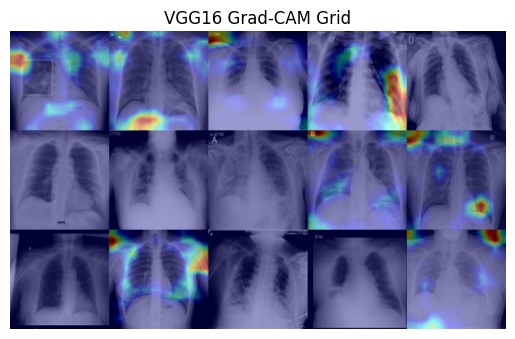

Grid image saved to: vgg16_gradcam_grid.jpg


In [ ]:
def create_gradcam_grid(image_dir, output_image_path, image_size=(128, 128), cols=5):
    """
    Loads saved Grad-CAM images and arranges them in a grid.
    """
    image_dir = Path(image_dir)
    image_files = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])[:15]

    all_images = []
    for img_name in image_files:
        img_path = image_dir / img_name
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Failed to load: {img_path}")
            continue
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        all_images.append(img)

    # Create blank canvas for grid
    num_images = len(all_images)
    rows = (num_images + cols - 1) // cols
    grid_image = np.zeros((rows * image_size[1], cols * image_size[0], 3), dtype=np.uint8)

    for idx, img in enumerate(all_images):
        row = idx // cols
        col = idx % cols
        y = row * image_size[1]
        x = col * image_size[0]
        grid_image[y:y + image_size[1], x:x + image_size[0], :] = img

    # Save and display
    cv2.imwrite(output_image_path, cv2.cvtColor(grid_image, cv2.COLOR_RGB2BGR))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.title('Grad-CAM Results Grid')
    plt.show()

    print(f" Grid image saved to: {output_image_path}")

# Run it
create_gradcam_grid(
    image_dir=save_dir,
    output_image_path=model_name + "_gradcam_grid.jpg"
)

